In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
fc = tf.feature_column

In [4]:
df_trn = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
df_val = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

y_trn = df_trn.pop('survived')
y_val = df_val.pop('survived')

In [5]:
df_trn.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
df_trn.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


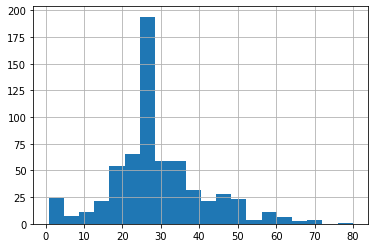

In [7]:
df_trn.age.hist(bins=20)

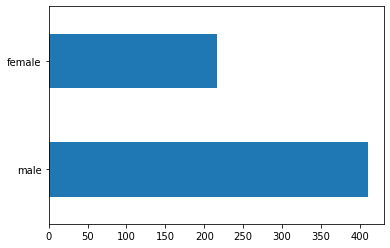

In [8]:
df_trn.sex.value_counts().plot(kind='barh')

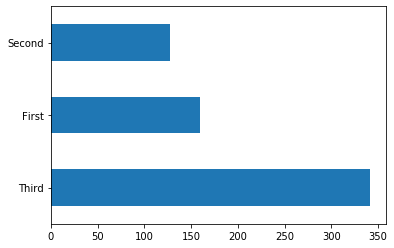

In [9]:
df_trn['class'].value_counts().plot(kind='barh')

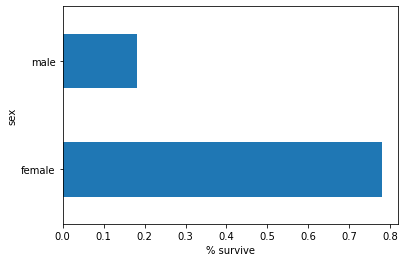

In [10]:
ax = pd.concat([df_trn, y_trn], axis=1).groupby('sex').survived.mean().plot(kind='barh')
ax.set_xlabel('% survive')
plt.show()

In [11]:
categorical_columns = ['sex', 'parch', 'class', 'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare', 'n_siblings_spouses']
feature_columns = []

In [12]:
for feature_name in categorical_columns:
    vocabulary = df_trn[feature_name].unique()
    feature_columns.append(fc.categorical_column_with_vocabulary_list(feature_name, vocabulary))
for feature_name in numeric_columns:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [13]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn

In [14]:
def make_input_fn(df_data, df_label, num_epochs=10, shuffle=True, batch_size=32):
    def input_fn():
        ds = tf.data.Dataset.from_tensor_slices((dict(df_data), df_label))
        if shuffle:
            ds = ds.shuffle(1024)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_fn

In [15]:
input_fn_trn = make_input_fn(df_trn, y_trn)
input_fn_val = make_input_fn(df_val, y_val)

In [16]:
ds = make_input_fn(df_trn, y_trn, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Feature keys:', list(feature_batch.keys()))
    print('A batch of class:', feature_batch['class'].numpy())
    print('A batch of labels:', label_batch.numpy())

Feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of class: [b'Third' b'Third' b'First' b'Third' b'First' b'Second' b'Third' b'First'
 b'First' b'Third']
A batch of labels: [0 0 0 0 1 1 0 1 1 0]


In [17]:
age_column = feature_columns[6]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[38.],
       [23.],
       [39.],
       [17.],
       [33.],
       [29.],
       [ 1.],
       [36.],
       [27.],
       [ 7.]], dtype=float32)

In [18]:
sex_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(sex_column)])(feature_batch).numpy()

W0611 10:10:34.155481 40384 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2655: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0611 10:10:34.161482 40384 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:4215: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0611 10:10:34.162481 40384 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:4270: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [19]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(input_fn_trn)

W0611 10:10:34.174481 40384 estimator.py:1811] Using temporary folder as model directory: C:\Users\Michael\AppData\Local\Temp\tmpqnov8t_y
W0611 10:10:34.182481 40384 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0611 10:10:35.152475 40384 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:308: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0611 10:10:35.612473 40384 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\ftrl.py:142: calling Constant.__init__ (

In [20]:
result_trn = linear_est.evaluate(input_fn_trn)
print(result_trn)

W0611 10:10:49.045915 40384 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


{'accuracy': 0.8181818, 'accuracy_baseline': 0.61244017, 'auc': 0.8684146, 'auc_precision_recall': 0.84823763, 'average_loss': 0.4270676, 'label/mean': 0.3875598, 'loss': 0.42655328, 'precision': 0.8, 'prediction/mean': 0.39482835, 'recall': 0.7078189, 'global_step': 200}


In [21]:
result_val = linear_est.evaluate(input_fn_val)
clear_output()
print(result_val)

{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.83180285, 'auc_precision_recall': 0.8023037, 'average_loss': 0.47907987, 'label/mean': 0.375, 'loss': 0.46891877, 'precision': 0.7, 'prediction/mean': 0.39691454, 'recall': 0.6363636, 'global_step': 200}


In [22]:
# age_x_sex = tf.feature_column.crossed_column
sex_column_indicator = tf.feature_column.indicator_column(sex_column)
tf.keras.layers.DenseFeatures([sex_column_indicator])(feature_batch).numpy()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [23]:
sex_x_age = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [24]:
derived_feature_columns = [sex_x_age]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns + derived_feature_columns)
linear_est.train(input_fn_trn)
result_trn = linear_est.evaluate(input_fn_val)
clear_output()
print(result_trn)

{'accuracy': 0.7651515, 'accuracy_baseline': 0.625, 'auc': 0.8483012, 'auc_precision_recall': 0.7934912, 'average_loss': 0.47373587, 'label/mean': 0.375, 'loss': 0.47576636, 'precision': 0.7126437, 'prediction/mean': 0.35716605, 'recall': 0.6262626, 'global_step': 200}


In [25]:
pred_dicts = list(linear_est.predict(input_fn_val))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

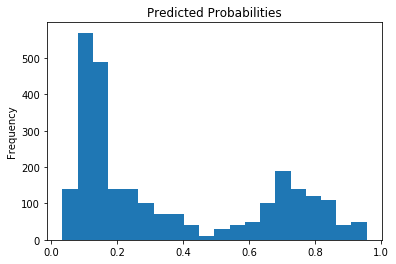

In [26]:
probs.plot(kind='hist', bins=20, title = 'Predicted Probabilities')

In [27]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [28]:
fpr, tpr, _ = roc_curve(y_val, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

ValueError: Found input variables with inconsistent numbers of samples: [264, 2640]